# Starting with Imports

Well--uh--it works

In [0]:
!pip install gensim
!curl https://course-v3.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   287  100   287    0     0    538      0 --:--:-- --:--:-- --:--:--   537
bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">'


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [0]:
from fastai import *
from fastai.text import *
from gensim.corpora import WikiCorpus

In [0]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [0]:
bs=48

# Some Callbacks

In [0]:
from fastai.callbacks import *
class EarlyStoppingMod(TrackerCallback):
    "A `TrackerCallback` that terminates training when monitored quantity stops improving."
    def __init__(self, learn:Learner, monitor:str='valid_loss',expected_value:int=0):
        super().__init__(learn, monitor=monitor, mode="auto") 
        self.expected_value = expected_value

    def on_train_begin(self, **kwargs:Any)->None:
        "Initialize inner arguments."
        super().on_train_begin(**kwargs)

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe stop training."
        current = self.get_monitor_value()
        if not current : 
          return None
        print(f"Heyya, This is Current : {current} and expected value {self.expected_value}")
        if current <= self.expected_value:
          print(f"Whohoo! The current {monitor} is less than expected")
          return {"stop_training":True}

# Downloading WikiPedia

- First downloading wikipedia dump, you can find wikipedia dump at `https://dumps.wikimedia.org/{language_id_you_want}wiki/` 
Indonesian wiki can be found [here](https://dumps.wikimedia.org/idwiki/20190520/idwiki-20190520-pages-articles-multistream.xml.bz2)



In [0]:
!curl -O https://dumps.wikimedia.org/idwiki/20190520/idwiki-20190520-pages-articles-multistream.xml.bz2
path = Path('/gdrive/My Drive/data/idwiki') #Downloading this in idwiki folder in your mounted google drive

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  537M  100  537M    0     0  2009k      0  0:04:33  0:04:33 --:--:-- 2033k


Refer [this notebook](https://github.com/dzlab/deepprojects/blob/master/nlp/ULMFiT_Arabic_LM.ipynb) for the download scripts for making wikipedia corpus on any language

In [0]:
def next_fname(output_dir, num=0):
    """Get the next filename to use for writing new articles."""
    count = 0
    fname = output_dir + '/' + '{:>07d}'.format(num) + '.txt' #What the fuck does this even mean or do?
    return count, (num+1), fname


def make_corpus(input_file, output_dir, size=10000):
    """Convert Wikipedia xml dump file to text corpus
    
    Note: You can set max number of size. Save space and your mental energy when dealing with stuff
    
    """
    print("loading wiki")
    wiki = WikiCorpus(input_file)#Makes WikiCorpus check `https://radimrehurek.com/gensim/corpora/wikicorpus.html` for documentation
    count, num, fname = next_fname(output_dir) #Give you the next file name for article
    print(f"count, num, fname : {count, num, fname}")
    output = open(fname, 'w')

    # iterate over texts and store them
    for text in wiki.get_texts():
        output.write(bytes(' '.join(text), 'utf-8').decode('utf-8') + '\n')
        count += 1
        if (count == size):
            print('%s Done.' % fname)
            output.close()
            count, num, fname = next_fname(output_dir, num)
            output = open(fname, 'w')
            break #because we only really need one file for training the model for now. 

    # clean up resources
    output.close()
    print('Completed.')
    return wiki
    
wiki = make_corpus('idwiki-20190520-pages-articles-multistream.xml.bz2',path.as_posix())

In [0]:
!mkdir data
!cp /gdrive/My\ Drive/data/idwiki/0000000.txt data/ # copying the data from gdrive to data
PATH = Path('./data'); PATH.ls()

In [0]:
!head data/0000000.txt

In [0]:
!wc -l data/0000000.txt #Gives Word Count

In [0]:
df = pd.read_csv(Path(path)/'0000000.txt', header=None); df.head() #Sanity Check

In [0]:
"""
Change this to use LangTokenizer directly from Fastai
"""
class LangTokenizer(BaseTokenizer):
    def __init__(
        self, lang: str, vocab_size: int = 60000, path_to_sp=f"sentencepiece/"):
        self.lang = lang
        self.vocab_size = vocab_size
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(path_to_sp + f"{lang}_lm.model")
        self.vocab = Vocab([self.sp.IdToPiece(int(i)) for i in range(self.vocab_size)]) #Read about what this does exactly

    def tokenizer(self, t: str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

    def detokenizer(self, t: List[str]) -> str:
        return self.sp.DecodePieces(t)
      
# tokenizer= Tokenizer(tok_func=LangTokenizer, lang="id") #Also What Fastai does with this Tokenizer class, what does it exactly do

In [0]:
"""
We are using sentencepiece Tokenizer because it's language independant, this downloads sentencepiece
"""
!cp /gdrive/My\ Drive/ULMFiTSum/sentencepiece.tar.gz data/
!tar -xvf data/sentencepiece.tar.gz
!pip install sentencepiece
import sentencepiece as spm
spm.SentencePieceProcessor()
tokenizer= Tokenizer(tok_func=LangTokenizer, lang="id") #Also What Fastai does with this Tokenizer class, what does it exactly do

sentencepiece/
sentencepiece/id_lm.model
sentencepiece/hi_lm.vocab
sentencepiece/hi_lm.model
sentencepiece/de_lm.model
sentencepiece/id_lm.vocab


In [0]:
PATH = Path('./data'); PATH.ls()

[PosixPath('data/data_lm.pkl'),
 PosixPath('data/indosum_test.csv'),
 PosixPath('data/data_save.pkl'),
 PosixPath('data/indosum_dev.csv'),
 PosixPath('data/models'),
 PosixPath('data/indosum_train.csv'),
 PosixPath('data/0000000.txt'),
 PosixPath('data/sentencepiece.tar.gz')]

In [0]:
data_lm = TextLMDataBunch.from_csv(PATH, 
                                   '0000000.txt', 
                                   tokenizer=tokenizer, 
                                   bs=48, 
                                   header=None, 
                                   text_cols=0, 
                                   label_cols=None)
data_lm.save(file="idwiki_data.pkl")

In [0]:
# !mkdir data/
!ls data

0000000.txt    idwiki_data.pkl	 indosum_train.csv
data_lm.pkl    indosum_dev.csv	 models
data_save.pkl  indosum_test.csv  sentencepiece.tar.gz


In [0]:
# !cp data/idwiki_data.pkl /gdrive/My\ Drive/data/
# !cp /gdrive/My\ Drive/data/data_save.pkl data/idwiki_data.pkl

In [0]:
PATH = Path('./data'); PATH.ls()
data_lm = load_data(PATH,file="idwiki_data.pkl", bs=bs)

In [0]:
data_lm.show_batch()

idx,text
0,▁bahasa ▁ hong aria ▁diperkirakan ▁berasal ▁dari ▁siber ia ▁dengan ▁nama ▁ ono guo roi ▁namun ▁asal ▁usul ▁mereka ▁masih ▁sangat ▁kabur ▁dan ▁sulit ▁dibuktikan ▁ada ▁juga ▁yang ▁meng kaitkan ▁hubungan ▁antara ▁bahasa ▁ hong aria ▁dengan ▁bahasa ▁kaum ▁ hun ▁yang ▁pernah ▁menguasai ▁padang ▁rumput ▁asia ▁tengah ▁hingga ▁eropa ▁namun ▁hal ▁ini ▁juga ▁masih ▁diragukan ▁kelompok ▁bahasa ▁ hong aria ▁digolongkan ▁dalam ▁bahasa ▁fin no ▁ ug rik ▁menarik
1,▁view ▁to ▁the ▁town ▁lu cas kerk ▁and ▁tower ▁near ▁ lies veld via duk t ▁file ▁v la ard ingen ▁o ude ▁sta ds huis ▁ jpg ▁ old ▁town ▁hal l ▁file ▁v la ard ingen ▁ vis bank ▁ jpg ▁ vis bank ▁file ▁v la ard ingen ▁bru g ▁a chter ▁de ▁ vis bank ▁ jpg ▁o ude ▁ haven br ug ▁file ▁v la
2,▁keju ▁setelah ▁dibuka ▁dan ▁tidak ▁ditaruh ▁di ▁lemari ▁pendingin ▁keju ▁segar ▁beberapa ▁hari ▁hingga ▁dua ▁minggu ▁lebih ▁keju ▁lunak ▁dua ▁minggu ▁bila ▁ditaruh ▁dalam ▁bungkus ▁plastik ▁keju ▁semi ▁lunak ▁dua ▁hingga ▁empat ▁minggu ▁keju ▁keras ▁lima ▁minggu ▁hingga ▁beberapa ▁bulan ▁keju ▁sangat ▁keras ▁lebih ▁dari ▁satu ▁tahun ▁berbagai ▁macam ▁keju ▁di ▁saji kan ▁dalam ▁satu ▁piring ▁penyajian ▁keju ▁harus ▁selalu ▁disajikan ▁bersuhu ▁ruangan ▁dan ▁bukan ▁keju ▁dingin ▁langsung ▁dari ▁lemari
3,▁dengan ▁ anne ▁fra nk ▁ search ing ▁for ▁ anne ▁fra nk ▁ letter s ▁from ▁am ster dam ▁to ▁i owa ▁buku ▁tanya ▁sa vi chev a ▁seorang ▁anak ▁soviet ▁penulis ▁buku ▁harian ▁yang ▁mengalami ▁pengepungan ▁le ning rad ▁pada ▁masa ▁perang ▁dunia ▁ ii ▁catatan ▁dan ▁referensi ▁catatan ▁pen jelas ▁kutipan ▁daftar ▁pustaka ▁this ▁edition ▁new ▁trans lation ▁ include s ▁material ▁ex c lud ed ▁from
4,▁kota ▁dan ▁kota ▁terbesar ▁di ▁prefektur ▁naga saki ▁yang ▁terletak ▁di ▁pesisir ▁sebelah ▁barat ▁daya ▁ kyu shu ▁jepang ▁lokasi ▁geografisnya ▁adalah ▁lu ▁b t ▁naga saki ▁adalah ▁pusat ▁pengaruh ▁eropa ▁di ▁jepang ▁pada ▁zaman ▁pertengahan ▁kota ▁naga saki ▁yang ▁merupakan ▁kota ▁pelabuhan ▁di ▁jepang ▁merupakan ▁kota ▁yang ▁tidak ▁terisolasi ▁pada ▁waktu ▁jepang ▁menerapkan ▁politik ▁isolasi ▁ sak koku ▁pengaruh ▁eropa ▁juga ▁sangat ▁terlihat ▁dengan ▁pesat nya ▁perkembangan ▁agama ▁kristen


In [0]:
!cp /gdrive/My\ Drive/data/indosum_* data/

In [0]:
!ls data

0000000.txt    idwiki_data.pkl	 indosum_train.csv
data_lm.pkl    indosum_dev.csv	 models
data_save.pkl  indosum_test.csv  sentencepiece.tar.gz


In [0]:
data_lm_indosum = TextLMDataBunch.from_csv(PATH, 
                                   'indosum_train.csv', 
                                   tokenizer=tokenizer, 
                                   bs=48, 
                                   header=None, 
                                   text_cols=0, 
                                   label_cols=None,
                                   vocab = data_lm.vocab)
data_lm_indosum.save(file="indosum_data.pkl")

In [0]:
!cp data/*_data.pkl /gdrive/My\ Drive/data/

In [0]:
!ls data/models

idwiki-13.pth  idwiki-4.pth  indosum-1.pth			tmp.pth
idwiki-1.pth   idwiki-6.pth  indowiki_encoder_attempt1.enc.pth
idwiki-2.pth   idwiki-8.pth  indowiki_encoder_attempt2.enc.pth


# Training


In [0]:
learn = language_model_learner(data_lm, 
                               AWD_LSTM, 
                               drop_mult=0.3, 
                               pretrained=False,
                              metrics=[accuracy, Perplexity()]).to_fp16()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 10e-1)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,nan,nan,0.000657,nan,30:46


In [0]:
learn.save('idwiki-1')
learn.data.vocab.save('idwiki-1_vocab.pkl')
!cp -r data/models /gdrive/My\ Drive/data_final/

In [0]:
# !ls data/models

In [0]:
PATH = Path('/gdrive/My Drive/data')
data_lm = load_data(PATH, bs=bs)
learn = language_model_learner(data_lm, 
                               AWD_LSTM, 
                               drop_mult=0.3, 
                               pretrained=False,
                              metrics=[accuracy, Perplexity()]).to_fp16()

In [0]:
learn.load('idwiki-1')
learn.unfreeze()

In [0]:
!cp -r data/models /gdrive/My\ Drive/data/
learn.fit_one_cycle(10, 10e-1)
learn.save(f'idwiki-11')
learn.data.vocab.save('idwiki-11_vocab.pkl')
learn.save_encoder("idwiki_encoder.enc")

In [0]:
!cp -r data/models /gdrive/My\ Drive/data_final/

#Indosum Training 

In [0]:
!cp -r /gdrive/My\ Drive/data_final/models data/

In [0]:
learn = language_model_learner(data_lm_indosum, 
                               AWD_LSTM, 
                               drop_mult=0.3,
                               metrics=[accuracy, Perplexity()],
                              callback_fns=[partial(EarlyStoppingMod, 
                                                    monitor='perplexity', 
                                                    expected_value=30)]).to_fp16()
learn.load_encoder("indowiki_encoder_attempt2.enc")
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


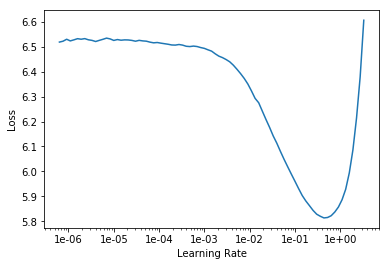

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 5e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time


In [0]:
learn.save('indosum-1')
learn.data.vocab.save('indosum-1_vocab.pkl')

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(50, 5e-1)
learn.save('indosum-30')
learn.data.vocab.save('indosum-30_vocab.pkl')

In [0]:
!cp -r data/models /gdrive/My\ Drive/data_final/